--- 1. Memuat Data ---
Data berhasil dimuat.
Total Transaksi: 2240 baris
        Date       FullName  Amount
0 2009-01-01  Leonie Köhler    0.99
1 2009-01-01  Leonie Köhler    0.99
2 2009-01-02   Bjørn Hansen    0.99
3 2009-01-02   Bjørn Hansen    0.99
4 2009-01-02   Bjørn Hansen    0.99

--- 2. Mulai Clustering (Segmentasi Pelanggan) ---

Karakteristik Tiap Cluster:
            Recency  Frequency   Monetary
Cluster                                  
0        214.468085       38.0  38.279574
1        572.000000       36.0  36.640000
2        154.727273       38.0  44.801818
Grafik 'clustering_result.png' disimpan.


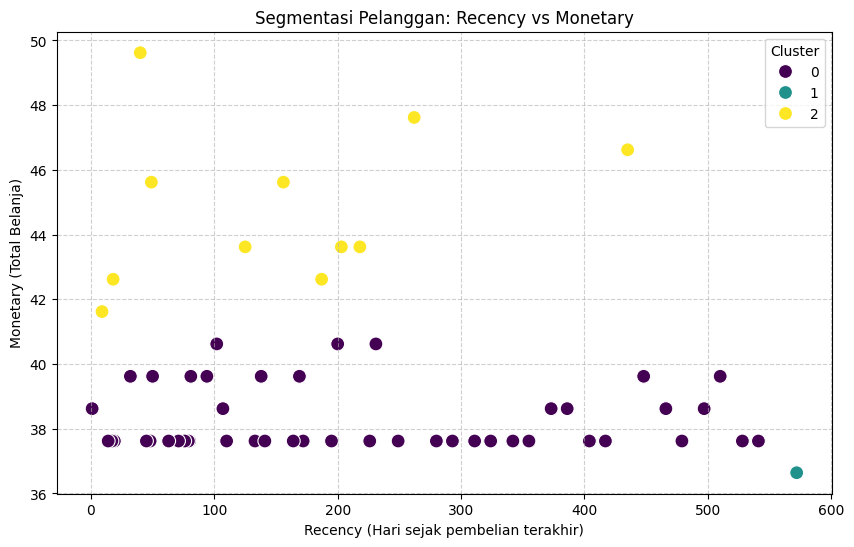


--- 3. Mulai Regresi (Prediksi Penjualan Bulanan) ---
Koefisien Kemiringan (Slope): -0.0056
R-Squared (Akurasi Tren): 0.0004
Kesimpulan: Tren penjualan MENURUN/STAGNAN.
Grafik 'regression_result.png' disimpan.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


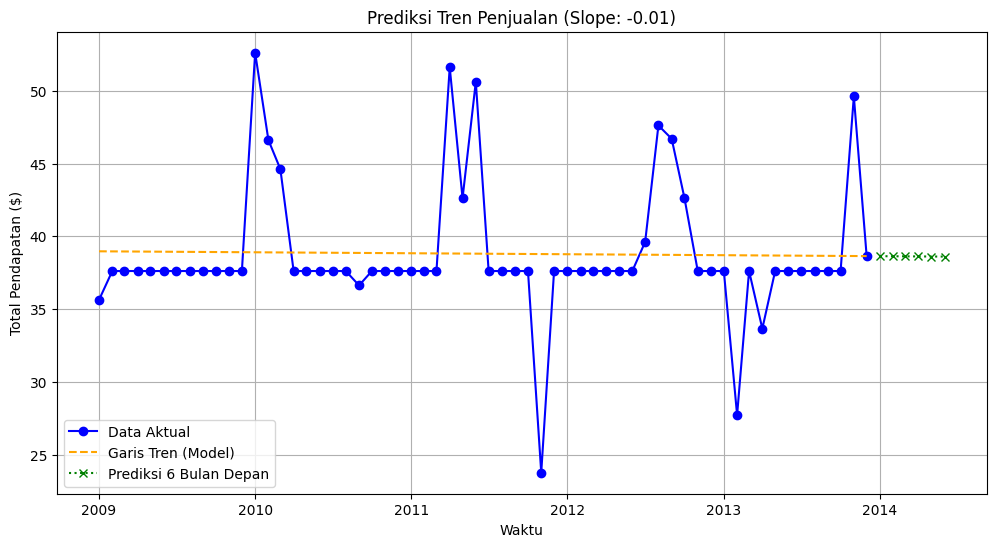


--- 4. MENYIMPAN HASIL UNTUK DASHBOARD ---
File 'hasil_clustering.csv' berhasil disimpan.
File 'hasil_forecasting.csv' berhasil disimpan.

--- Selesai ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# 1. LOAD & PREPARE DATA
try:
    fact_sales = pd.read_csv('fact_penjualan.csv', sep=',')
    dim_pelanggan = pd.read_csv('dim_pelanggan.csv', sep=',')
    dim_waktu = pd.read_csv('dim_waktu.csv', sep=',')
    print("Data berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Pastikan file 'fact_penjualan.csv', 'dim_pelanggan.csv', dan 'dim_waktu.csv' ada.")

sales_data = pd.merge(fact_sales, dim_waktu, on='DateID', how='left')

sales_data = pd.merge(sales_data, dim_pelanggan, on='CustomerID', how='left')

sales_data['Date'] = pd.to_datetime(sales_data['FullDate'])

print(f"Total Transaksi: {len(sales_data)} baris")
print(sales_data[['Date', 'FullName', 'Amount']].head())


# 2. UNSUPERVISED LEARNING: CLUSTERING (RFM)
snapshot_date = sales_data['Date'].max() + pd.Timedelta(days=1)

rfm = sales_data.groupby('CustomerID').agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'FactSalesID': 'count',
    'Amount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("\nKarakteristik Tiap Cluster:")
print(rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean())

# Visualisasi Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100)
plt.title('Segmentasi Pelanggan: Recency vs Monetary')
plt.xlabel('Recency (Hari sejak pembelian terakhir)')
plt.ylabel('Monetary (Total Belanja)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('clustering_result.png')
print("Grafik 'clustering_result.png' disimpan.")
plt.show()



# 3. SUPERVISED LEARNING: REGRESSION (FORECASTING)

sales_data['MonthYear'] = sales_data['Date'].dt.to_period('M')
monthly_sales = sales_data.groupby('MonthYear')['Amount'].sum().reset_index()
monthly_sales['DatePlot'] = monthly_sales['MonthYear'].dt.to_timestamp()
monthly_sales['TimeIndex'] = np.arange(len(monthly_sales))

# Siapkan Variabel X dan Y
X = monthly_sales[['TimeIndex']]
y = monthly_sales['Amount']

# Modeling Linear Regression
reg = LinearRegression()
reg.fit(X, y)

# Prediksi (Garis Tren)
y_pred = reg.predict(X)

# Prediksi Masa Depan (6 Bulan ke depan)
last_index = monthly_sales['TimeIndex'].iloc[-1]
future_X = np.arange(last_index + 1, last_index + 7).reshape(-1, 1)
future_pred = reg.predict(future_X)
future_dates = [monthly_sales['DatePlot'].iloc[-1] + pd.DateOffset(months=i) for i in range(1, 7)]

# Evaluasi Model
r2 = r2_score(y, y_pred)
slope = reg.coef_[0]

print(f"Koefisien Kemiringan (Slope): {slope:.4f}")
print(f"R-Squared (Akurasi Tren): {r2:.4f}")
if slope > 0:
    print("Kesimpulan: Tren penjualan MENINGKAT.")
else:
    print("Kesimpulan: Tren penjualan MENURUN/STAGNAN.")

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['DatePlot'], y, marker='o', label='Data Aktual', color='blue')
plt.plot(monthly_sales['DatePlot'], y_pred, linestyle='--', color='orange', label='Garis Tren (Model)')
plt.plot(future_dates, future_pred, linestyle=':', marker='x', color='green', label='Prediksi 6 Bulan Depan')

plt.title(f'Prediksi Tren Penjualan (Slope: {slope:.2f})')
plt.xlabel('Waktu')
plt.ylabel('Total Pendapatan ($)')
plt.legend()
plt.grid(True)
plt.savefig('regression_result.png')
print("Grafik 'regression_result.png' disimpan.")
plt.show()



# 1. Simpan Hasil Clustering
rfm.to_csv('hasil_clustering.csv', index=False)
print("File 'hasil_clustering.csv' berhasil disimpan.")

# 2. Simpan Hasil Regresi (Gabungan Data Asli + Masa Depan)
# A. Data Historis
history_df = monthly_sales[['DatePlot', 'Amount']].copy()
history_df['Type'] = 'Actual' # Penanda data asli

# B. Data Prediksi Masa Depan
future_df = pd.DataFrame({
    'DatePlot': future_dates,
    'Amount': future_pred,
    'Type': 'Forecast'
})

final_forecast = pd.concat([history_df, future_df], ignore_index=True)
final_forecast['DatePlot'] = final_forecast['DatePlot'].dt.strftime('%Y-%m-%d')
final_forecast.to_csv('hasil_forecasting.csv', index=False)
print("File 'hasil_forecasting.csv' berhasil disimpan.")


In [ ]:


fact_sales = pd.read_csv('fact_penjualan.csv', sep=',')
fact_sales.head()

,FactSalesID,DateID,CustomerID,TrackID,Quantity,Amount
0,11398,20090101,2,2,1,0.99
1,11399,20090101,2,4,1,0.99
2,11400,20090102,4,6,1,0.99
3,11401,20090102,4,8,1,0.99
4,11402,20090102,4,10,1,0.99
